In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from tqdm import tqdm

In [ ]:
# 1. Load data
train = pd.read_parquet("data/train_data.parquet")
events = pd.read_parquet("data/add_event.parquet")
trans = pd.read_parquet("data/add_trans.parquet")
offers = pd.read_parquet("data/offer_metadata.parquet")
test = pd.read_parquet("data/test_data.parquet")

In [4]:
events.head()

,id2,id3,id6,id4,id7
0,2431360,618619,Tiles,2023-10-22 08:08:17.768,None
1,2431360,363153,Tiles,2023-10-22 08:08:18.921,None
2,2431360,97193,Tiles,2023-10-22 08:08:17.765,None
3,2431360,654444,Tiles,2023-10-22 08:08:17.737,None
4,2431360,32325,Tiles,2023-10-22 08:08:17.812,None


In [5]:
# 2. Standardize missing markers
for df in [train, test, events, offers]:
    df.replace({-9999.0: pd.NA, None: pd.NA, 'NULL':pd.NA}, inplace=True)

In [6]:
for df in [train, test]:
    df['id4'] = pd.to_datetime(df['id4'])
    df['id5'] = pd.to_datetime(df['id5'], errors='coerce').dt.date
offers['id12'] = pd.to_datetime(offers['id12'])
offers['id13'] = pd.to_datetime(offers['id13'])
events['id4'] = pd.to_datetime(events['id4'])
events['id7'] = pd.to_datetime(events['id7'])
# trans['f370'] = pd.to_datetime(trans['f370'])

In [7]:
# 4. Drop features with >99% missing
missing_pct = train.isna().mean()
drop_cols = missing_pct[missing_pct > 0.99].index
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=[c for c in drop_cols if c in test.columns], inplace=True)

In [8]:
dict_df = pd.read_csv(r'data/data_dictionary.csv')
dict_df

,masked_column,Description,Type
0,id1,Primary Key(masked),Key
1,id2,Customer ID (masked),-
2,id3,Offer ID,Categorical
3,id4,Event timestamp,Numerical
4,id5,Event Date,Numerical
...,...,...,...
367,f362,Total clicks on the incoming offer's industry ...,Numerical
368,f363,CTR on the incoming offer's industry for the g...,Numerical
369,f364,CM’s past 6 moth impressions on relevant offers,Numerical
370,f365,CM’s past 6 moth clicks on relevant offers,Numerical


In [9]:
# Make lists of columns by type if present in train
cat_cols = dict_df[dict_df['Type'] == 'Categorical']['masked_column']
num_cols = dict_df[dict_df['Type'] == 'Numerical']['masked_column']
ohe_cols = dict_df[dict_df['Type'] == 'One hot encoded']['masked_column']

# Keep only those present in train
cat_cols = [col for col in cat_cols if col in train.columns and train[col].dtype == 'object']
num_cols = [col for col in num_cols if col in train.columns and train[col].dtype == 'object']
ohe_cols = [col for col in ohe_cols if col in train.columns and train[col].dtype == 'object']

print("Categorical:", cat_cols)
print("Numerical:", num_cols)
print("One hot encoded:",ohe_cols)

Categorical: ['id3', 'f42', 'f48', 'f50', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f349', 'f354']
Numerical: ['id5', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f35', 'f36', 'f38', 'f39', 'f40', 'f41', 'f43', 'f44', 'f45', 'f46', 'f47', 'f49', 'f51', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f81', 'f82', 'f83', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f121', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148',

In [10]:
train['f226'].unique()

array(['0.0', <NA>], dtype=object)

In [20]:
for col in tqdm(cat_cols, desc="Casting categorical columns"):
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

for col in tqdm(num_cols, desc="Casting numerical columns"):
    train[col] = pd.to_numeric(train[col], errors='coerce').astype('float32')
    test[col] = pd.to_numeric(test[col], errors='coerce').astype('float32')

for col in tqdm(ohe_cols, desc="Cleaning and casting one-hot encoded columns"):
    train[col] = train[col].replace({'1.0': 1, '0.0': 0, 0.0: 0, 1.0: 1})
    test[col] = test[col].replace({'1.0': 1, '0.0': 0, 0.0: 0, 1.0: 1})
    try :
        train[col] = pd.to_numeric(train[col], errors='coerce').where(lambda x: x.isin([0, 1]), pd.NA).astype('Int8')
    except :
        print(col)
    test[col] = pd.to_numeric(test[col], errors='coerce').where(lambda x: x.isin([0, 1]), pd.NA).astype('Int8')

Cleaning and casting one-hot encoded columns: 100%|██████████| 84/84 [01:10<00:00,  1.19it/s]


In [12]:
def feature_engineer(df, events, offers,trans):
    ctr = events.assign(clicked=events['id7'].notna().astype(int))
    df = df.copy()

    # unify keys
    df['id3'] = df['id3'].astype(str)
    ctr['id3'] = ctr['id3'].astype(str)
    offers_loc = offers.copy()
    offers_loc['id3'] = offers_loc['id3'].astype(str)

    # 1) Existing CTR Features (Offer-level only)
    o_imp = ctr.groupby('id3').size().rename('imps')
    o_click = ctr[ctr.clicked == 1].groupby('id3').size().rename('clicks')
    offer_stats = (
        pd.concat([o_imp, o_click], axis=1)
          .fillna(0)
          .assign(ctr=lambda x: x.clicks / x.imps)
          .reset_index()
    )
    df = df.merge(offer_stats[['id3', 'ctr']], on='id3', how='left')

    stats = offer_stats.copy()
    a, b = 1, 1
    stats['ctr_smooth'] = (stats.clicks + a) / (stats.imps + a + b)
    df = df.merge(stats[['id3', 'ctr_smooth']], on='id3', how='left')

    # 2) Offer Metadata
    df = df.merge(
        offers_loc[['id3', 'f375', 'f376', 'id12', 'id13', 'id11', 'id10']],
        on='id3', how='left'
    )

    # 3) Popularity in last 30 days (offer-level only)
    last_date = df['id4'].max()
    cutoff_pop = last_date - pd.Timedelta(days=30)
    recent_imps = events[events['id4'] >= cutoff_pop].astype({'id3': str})
    total_recent = len(recent_imps)
    pop30 = recent_imps.groupby('id3').size().rename('offer_imps_30d')
    df['offer_popularity_30d'] = (
        df['id3']
          .map(pop30.div(total_recent))
          .fillna(0)
    )

    # 4) Temporal & Sequence Features
    df['hour'] = df['id4'].dt.hour
    df['dow'] = df['id4'].dt.dayofweek
    df = df.sort_values(['id2', 'id4'])
    df['prev_time'] = df.groupby('id2')['id4'].shift()
    df['secs_prev'] = (
        df['id4'] - df['prev_time']
    ).dt.total_seconds().fillna(-1)
    df['days_to_exp'] = (
        df['id13'] - df['id4']
    ).dt.days.clip(lower=0)

    # 5) Frequency & Brand Indicator
    df['ind_match'] = 0
    df['brand_freq'] = df['id11'].map(
        df['id11'].value_counts(normalize=True)
    )
        # --- 6) Event-driven offer trends ---

    # Recent click rate (7-day window)
    cutoff_7d = last_date - pd.Timedelta(days=7)
    recent_events = events[events['id4'] >= cutoff_7d].copy()
    recent_events['id3'] = recent_events['id3'].astype(str)
    recent_events['clicked'] = recent_events['id7'].notna().astype(int)

    recent_clicks = recent_events.groupby('id3')['clicked'].agg(['sum', 'count']).rename(
        columns={'sum': 'recent_clicks', 'count': 'recent_impressions'}
    )
    recent_clicks['offer_recent_click_rate'] = recent_clicks['recent_clicks'] / recent_clicks['recent_impressions']
    df = df.merge(recent_clicks[['offer_recent_click_rate']], on='id3', how='left')

    # Median hour of clicks per offer
    events['click_hour'] = events['id7'].dt.hour
    click_events = events[events['id7'].notna()].copy()
    median_click_hour = click_events.groupby('id3')['click_hour'].median().rename('offer_median_click_hour')
    df = df.merge(median_click_hour, on='id3', how='left')

    # Total impressions & clicks per offer
    click_count = click_events['id3'].value_counts().rename('offer_click_count')
    imp_count = events['id3'].value_counts().rename('offer_impression_count')
    df = df.merge(imp_count, left_on='id3', right_index=True, how='left')
    df = df.merge(click_count, left_on='id3', right_index=True, how='left')

    # CTR by offer + day of week
    events['dow'] = events['id4'].dt.dayofweek
    offer_dow_ctr = (
        events.assign(clicked=events['id7'].notna().astype(int))
              .groupby(['id3', 'dow'])['clicked']
              .agg(['sum', 'count'])
              .reset_index()
    )
    offer_dow_ctr['click_rate_by_dayofweek'] = offer_dow_ctr['sum'] / offer_dow_ctr['count']
    df = df.merge(
        offer_dow_ctr[['id3', 'dow', 'click_rate_by_dayofweek']],
        on=['id3', 'dow'], how='left'
    )
    ind_stats = (
        trans
        .copy()
        .astype({"id8": str})
        .groupby('id8')['f367']
        .agg(industry_tx_sum='sum', industry_tx_count='count')
        .reset_index()
    )
    # Merge these stats into the offers table by id8
    offers_loc = offers.copy()
    offers_loc['id8'] = offers_loc['id8'].astype(str)
    offers_ind = offers_loc.merge(
        ind_stats,
        on='id8', how='left'
    )
    # Bring enriched offer-level transaction features into df via id3
    df = df.merge(
        offers_ind[['id3','industry_tx_sum','industry_tx_count']].astype({'id3': str}),
        on='id3', how='left'
    )
    return df

train = feature_engineer(train, events, offers,trans)
test = feature_engineer(test, events, offers,trans)

In [13]:
train['f227'].unique()

<IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int8

In [14]:
offers.head()

,id3,id9,f375,f376,f377,id10,id11,f378,f374,id8,id12,id13
0,70687,FO5O,2,5.0,<NA>,1,<NA>,N,<NA>,<NA>,2018-01-01 00:00:00,2099-12-31 23:59:59
1,900002526,UGE,2,100.0,<NA>,1,<NA>,N,<NA>,<NA>,2014-10-20 00:00:00,2099-12-31 23:59:59
2,900002864,UTP,1,100.0,<NA>,1,<NA>,N,<NA>,<NA>,2016-07-19 00:00:00,2099-12-31 23:59:59
3,19508,o,2,NaN,<NA>,1,<NA>,N,<NA>,<NA>,2019-06-02 17:00:00,2028-12-31 16:59:59
4,35903,o,2,NaN,<NA>,1,<NA>,N,<NA>,<NA>,2019-06-02 17:00:00,2028-12-31 16:59:59


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770164 entries, 0 to 770163
Columns: 375 entries, id1 to industry_tx_count
dtypes: Int8(84), category(11), datetime64[ns](4), float32(251), float64(14), int32(2), int64(2), object(7)
memory usage: 1.0+ GB


In [18]:
# 6. Define features
num_features = [
    'ctr', 'ctr_smooth', 'secs_prev', 'days_to_exp',
    'brand_freq', 'offer_popularity_30d',
    'offer_recent_click_rate', 'offer_median_click_hour',
    'offer_impression_count', 'offer_click_count',
    'click_rate_by_dayofweek' , 'industry_tx_sum',      
    'industry_tx_count'
]
cat_ohe = ['f375','f376','hour','dow']
cat_ord = ['id11']
num_features += num_cols
cat_ohe += ohe_cols
cat_ord += cat_cols

# Cast categorical features to string
for col in cat_ohe + cat_ord:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

# 7. Build preprocessing pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('ohe', cat_pipeline, cat_ohe),
    ('ord', ord_pipeline, cat_ord)
], remainder='drop')

# Remove duplicates while preserving order
all_features = []
for col in num_features + cat_ohe + cat_ord:
    if col not in all_features:
        all_features.append(col)

with tqdm(total=2, desc="Fitting and transforming datasets") as pbar:
    X = preprocessor.fit_transform(train[all_features])
    pbar.update(1)
    X_test = preprocessor.transform(test[all_features])
    pbar.update(1)
y = train['y'].values

Fitting and transforming datasets:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\91820\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:597: UserWarning: Skipping features without any observed values: ['brand_freq' 'id5']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Fitting and transforming datasets:  50%|█████     | 1/2 [01:10<01:10, 70.58s/it]c:\Users\91820\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:597: UserWarning: Skipping features without any observed values: ['brand_freq' 'id5']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
Fitting and transforming datasets: 100%|██████████| 2/2 [01:21<00:00, 40.83s/it]


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770164 entries, 0 to 770163
Columns: 375 entries, id1 to industry_tx_count
dtypes: datetime64[ns](4), float32(251), float64(12), int64(2), object(106)
memory usage: 1.4+ GB


In [ ]:
# def get_feature_indices(preprocessor, feature_group_name):
#     """
#     Returns the indices of the transformed columns for a given transformer name.
#     """
#     current_index = 0
#     feature_indices = {}

#     for name, transformer, columns in preprocessor.transformers_:
#         if name == feature_group_name:
#             if hasattr(transformer, 'get_feature_names_out'):
#                 # Handle pipelines
#                 names = transformer.get_feature_names_out()
#             else:
#                 names = columns
#             n_cols = len(preprocessor.named_transformers_[name].transform(np.zeros((1, len(columns)))).flatten())
#             feature_indices[name] = list(range(current_index, current_index + n_cols))
#             break
#         else:
#             if hasattr(preprocessor.named_transformers_[name], 'transform'):
#                 transformed = preprocessor.named_transformers_[name].transform(
#                     np.zeros((1, len(columns)))
#                 )
#                 n_cols = transformed.shape[1]
#                 current_index += n_cols

#     return feature_indices.get(feature_group_name, [])


In [ ]:
try:
    feat_names = preprocessor.get_feature_names_out()
except:
    num_names = num_features
    ohe = preprocessor.named_transformers_['ohe']['onehot']
    ohe_cols = ohe.get_feature_names_out(cat_ohe)
    ord_cols = cat_ord
    feat_names = np.concatenate([num_names, ohe_cols, ord_cols])

# 2. get importances and pair
# importances = model.feature_importance(importance_type='gain')
# feat_imp = pd.DataFrame({
#     'feature': feat_names,
#     'importance': importances
# })

# # 3. sort and take top 50
# top50 = feat_imp.sort_values('importance', ascending=False).head(50)

# # 4. print them nicely
# print("Top 50 features by importance:")
# for i, (f, imp) in enumerate(zip(top50['feature'], top50['importance']), 1):
#     print(f"{i:2d}. {f:30s} {imp:.1f}")

In [26]:
# 8. Split and group
split_cut = train['id4'].quantile(0.8)
mask_val = train['id4'] > split_cut
mask_val_np = mask_val.to_numpy()  # 🛠️ Convert to NumPy array for sparse matrix indexing

X_trn, y_trn = X[~mask_val_np], y[~mask_val_np]
X_val, y_val = X[mask_val_np], y[mask_val_np]

id2_trn = train.loc[~mask_val, 'id2'].astype(str)
id2_val = train.loc[mask_val, 'id2'].astype(str)
group_trn = id2_trn.value_counts().sort_index().values
group_val = id2_val.value_counts().sort_index().values

In [ ]:
# buyers_mask = (y_trn >= 1)
# buyers_id2 = set(id2_trn[buyers_mask])

# # Keep only rows for customers who bought something
# keep_mask = id2_trn.isin(buyers_id2).to_numpy()

# # Apply mask to training data
# X_trn = X_trn[keep_mask]
# y_trn = y_trn[keep_mask]
# id2_trn = id2_trn[keep_mask]

# # 📦 Compute group sizes for ranking models
# group_trn = id2_trn.value_counts().sort_index().values
# group_val = id2_val.value_counts().sort_index().values

In [89]:
X_trn

array([], shape=(0, 538), dtype=float64)

In [27]:
from lightgbm import early_stopping, log_evaluation

# 9. LightGBM ranking (MAP@7) with callbacks for early stopping & logging
train_set = lgb.Dataset(X_trn, label=y_trn, group=group_trn)
val_set   = lgb.Dataset(X_val, label=y_val, group=group_val)

params = {
    'objective':       'lambdarank',
    'metric':          'map',
    'eval_at':         [7],
    'learning_rate':   0.01,
    'num_leaves':      32,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    # 'lambda_l1':       1.0,
    'bagging_freq':     5,
    'verbosity':       -1,
    'device_type' : 'gpu',
    'gpu_platform_id': 1,  # <-- set your platform id here
    'gpu_device_id':   0 ,
}

model = lgb.train(
    params,
    train_set,
    num_boost_round=1000,
    valid_sets=[train_set, val_set],
    valid_names=['train', 'valid'],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	train's map@7: 0.958997	valid's map@7: 0.959798
[200]	train's map@7: 0.960521	valid's map@7: 0.961066
Early stopping, best iteration is:
[211]	train's map@7: 0.960711	valid's map@7: 0.961297


In [28]:
def map_at_k(ids, y_true, y_pred, k=7):
    dfm = pd.DataFrame({
        'id2': ids,
        'y': y_true,
        'p': y_pred
    })
    # ensure y is numeric
    dfm['y'] = dfm['y'].astype(int)

    aps = []
    for _, g in dfm.groupby('id2'):
        top = g.sort_values('p', ascending=False).head(k)
        rel = top['y'].values
        if rel.sum() == 0:
            continue
        hits = 0
        score = 0.0
        for i, r in enumerate(rel, 1):
            if r == 1:
                hits += 1
                score += hits / i
        aps.append(score / min(rel.sum(), k))
    return np.mean(aps)

# Then:
val_preds = model.predict(X_val, num_iteration=model.best_iteration)
validation_map7 = map_at_k(id2_val, y_val, val_preds)
print("Validation MAP@7:", validation_map7)

Validation MAP@7: 0.7464608793369855


In [77]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRanker

In [82]:

# One-Hot Pipeline for XGBoost
xgb_pipeline = Pipeline([
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        use_label_encoder=False,
        random_state=42
    ))
])

# CatBoost uses raw categorical features
from catboost import CatBoostRanker
cat_pipeline = Pipeline([
     ('model', CatBoostRanker(
        cat_features=cat_ord,
        iterations=500,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        task_type='GPU',
        random_state=42,
        loss_function='YetiRank'
    ))
])

# Logistic Regression on scaled numeric features
logreg_pipeline = Pipeline([
    ('model', LogisticRegression(
        penalty='l2',
        solver='saga',
        class_weight='balanced',
        max_iter=5000,
        random_state=42
    ))
])


In [83]:
from lightgbm import LGBMRanker

# Train base models
base_models = [
    ("XGBoost", xgb_pipeline, X_trn[cat_ohe], y),
    ("CatBoost", cat_pipeline, X_trn[cat_ord], y),
    ("LogReg", logreg_pipeline, X_trn[num_features], y)
]

for name, pipe, X, y_ in tqdm(base_models, desc="Fitting base models"):
    print(f"Fitting {name}...")
    pipe.fit(X, y_)

# Generate predictions from base models
Z_trn = np.column_stack([
    xgb_pipeline.predict_proba(X_trn)[:, 1],
    cat_pipeline.predict_proba(X_trn[cat_ord])[:, 1],
    logreg_pipeline.predict_proba(X_trn)[:, 1],
])

Z_val = np.column_stack([
    xgb_pipeline.predict_proba(X_val)[:, 1],
    cat_pipeline.predict_proba(X_val[cat_ord])[:, 1],
    logreg_pipeline.predict_proba(X_val)[:, 1],
])

group_column = 'id2'
group_trn = X_trn[group_column].value_counts(sort=False).sort_index().values
group_val = X_val[group_column].value_counts(sort=False).sort_index().values

train_set = lgb.Dataset(Z_trn, label=y_trn, group=group_trn)
val_set = lgb.Dataset(Z_val, label=y_val, group=group_val)
print("Training meta model")
params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': [7],
    'learning_rate': 0.01,
    'num_leaves': 16,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': 1,
    'device_type': 'gpu',
    'gpu_platform_id': 1,
    'gpu_device_id': 0
}

model = lgb.train(
    params,
    train_set,
    num_boost_round=1000,
    valid_sets=[train_set, val_set],
    valid_names=['train', 'valid'],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [57]:
# --- after training your model and having X_test, test DataFrame ---

from scipy.special import expit
import pandas as pd

# 1) Get raw scores
raw_preds = model.predict(X_test, num_iteration=model.best_iteration)

# 2) Convert to (0,1) via sigmoid
prob_preds = expit(raw_preds)

# 3) Sanity‑check in memory
print("raw_preds[:5]       :", raw_preds[:5])
print("prob_preds[:5]      :", prob_preds[:5])
print("raw_preds min/max   :", raw_preds.min(), raw_preds.max())
print("prob_preds min/max  :", prob_preds.min(), prob_preds.max())

# 4) Build your submission DataFrame from prob_preds
sub = pd.DataFrame({
    'id1':  test['id1'],
    'id2':  test['id2'],
    'id3':  test['id3'],
    'id5':  test['id5'],
    'pred': prob_preds      # <<-- make sure this is prob_preds
})

# 5) Save to CSV
csv_path = 'r2_submission_file_sigmoid.csv'
sub.to_csv(csv_path, index=False)
print(f"Saved sigmoid submission to {csv_path!r}")

# 6) Reload and verify on‑disk values
df_check = pd.read_csv(csv_path)
print("Reloaded CSV pred min/max:", df_check['pred'].min(), df_check['pred'].max())
print(df_check.head(5))


raw_preds[:5]       : [-1.07019874 -4.41435069 -3.24979604 -0.61140498 -4.71154053]
prob_preds[:5]      : [0.25536529 0.01195769 0.03733422 0.35173877 0.0089108 ]
raw_preds min/max   : -5.712011075258827 3.6436183075431883
prob_preds min/max  : 0.003295123470653132 0.9745092484561793
Saved sigmoid submission to 'r2_submission_file_sigmoid.csv'
Reloaded CSV pred min/max: 0.0032951234706531 0.9745092484561791
                                             id1      id2      id3  id5  \
0     1000061_9914_16-23_2023-11-05 09:11:35.557  1000061     9914  NaN   
1    1000061_23690_16-23_2023-11-05 09:11:36.193  1000061    23690  NaN   
2   1000061_522188_16-23_2023-11-05 09:11:37.242  1000061   522188  NaN   
3  1000061_5420674_16-23_2023-11-05 09:28:04.153  1000061  5420674  NaN   
4    1000061_27945_16-23_2023-11-05 09:28:04.157  1000061    27945  NaN   

       pred  
0  0.255365  
1  0.011958  
2  0.037334  
3  0.351739  
4  0.008911  


In [96]:
sub.to_csv(csv_path, index=False)

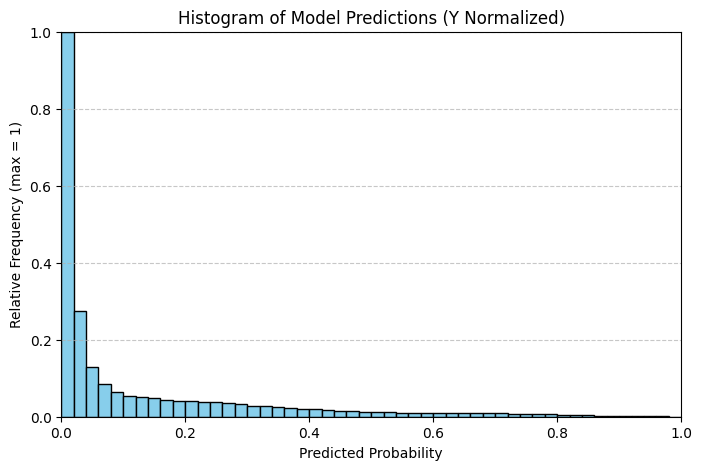

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
preds = sub['pred']

# Compute histogram manually
counts, bins = np.histogram(preds, bins=50, range=(0, 1))
counts = counts / counts.max()  # Normalize to max value 1

# Plot
plt.figure(figsize=(8, 5))
plt.bar(bins[:-1], counts, width=(bins[1] - bins[0]), color='skyblue', edgecolor='black', align='edge')
plt.title("Histogram of Model Predictions (Y Normalized)")
plt.xlabel("Predicted Probability")
plt.ylabel("Relative Frequency (max = 1)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [12]:
# --- after model = lgb.train(...) ---

# 1. get feature names
try:
    # scikit‑learn 1.0+ API
    feat_names = preprocessor.get_feature_names_out()
except AttributeError:
    # fallback for older versions: build names manually
    num_names = num_features
    # one‑hot names
    ohe = preprocessor.named_transformers_['ohe']['onehot']
    ohe_cols = ohe.get_feature_names_out(cat_ohe)
    # ordinal names
    ord_cols = cat_ord
    feat_names = np.concatenate([num_names, ohe_cols, ord_cols])

# 2. get importances and pair
importances = model.feature_importance(importance_type='gain')
feat_imp = pd.DataFrame({
    'feature': feat_names,
    'importance': importances
})

# 3. sort and take top 50
top50 = feat_imp.sort_values('importance', ascending=False).head(50)

# 4. print them nicely
print("Top 50 features by importance:")
for i, (f, imp) in enumerate(zip(top50['feature'], top50['importance']), 1):
    print(f"{i:2d}. {f:30s} {imp:.1f}")

Top 50 features by importance:
 1. num__secs_prev                 108287.7
 2. num__ctr                       50453.3
 3. num__ctr_smooth                25154.4
 4. num__offer_popularity_30d      6282.1
 5. num__days_to_exp               4831.8
 6. ohe__f375_2.0                  362.3
 7. ohe__f375_1.0                  336.9
 8. ohe__f376_nan                  312.0
 9. ohe__f376_100.0                269.2
10. ohe__dow_4                     194.9
11. ohe__hour_9                    140.6
12. ohe__hour_7                    129.8
13. ohe__hour_6                    122.9
14. ohe__hour_18                   120.9
15. ohe__hour_11                   117.6
16. ohe__hour_15                   116.4
17. ohe__hour_10                   115.7
18. ohe__hour_13                   113.2
19. ohe__hour_8                    112.4
20. ohe__hour_16                   108.0
21. ohe__dow_2                     98.6
22. ohe__hour_19                   97.2
23. ohe__dow_3                     91.3
24. ohe__f376_8.0   